**Chapter 7 – Ensemble Learning and Random Forests**

_This notebook contains all the sample code and solutions to the exercises in chapter 7._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/07_ensemble_learning_and_random_forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/07_ensemble_learning_and_random_forests.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.7 or above:

In [2]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [3]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

As we did in previous chapters, let's define the default font sizes to make the figures prettier:

In [4]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/ensembles` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [8]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ensembles"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Voting Classifiers

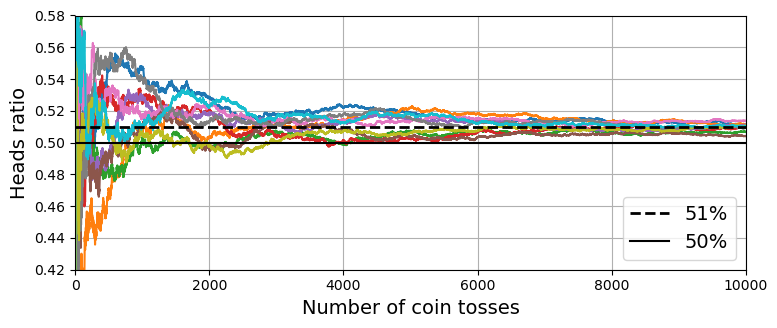

In [9]:
# extra code – this cell generates and saves Figure 7–3

import matplotlib.pyplot as plt
import numpy as np

heads_proba = 0.51
np.random.seed(42)
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads = coin_tosses.cumsum(axis=0)
cumulative_heads_ratio = cumulative_heads / np.arange(1, 10001).reshape(-1, 1)

plt.figure(figsize=(8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.grid()
save_fig("law_of_large_numbers_plot")
plt.show()

generating and visualizing a dataset using Scikit-learn and the make_moons() function:

X:  [[ 8.31039149e-01 -2.58748754e-01]
 [ 1.18506381e+00  9.20387143e-01]
 [ 1.16402213e+00 -4.55525583e-01]
 [-2.36556013e-02  1.08628844e+00]
 [ 4.80502733e-01  1.50942444e+00]
 [ 1.31164912e+00 -5.51176060e-01]
 [ 1.16542367e+00 -1.58629894e-01]
 [ 1.56736404e-01  1.31817168e+00]
 [ 4.53301022e-01  4.96074925e-01]
 [ 1.65139719e+00 -4.59804351e-01]
 [ 1.02664982e+00 -1.56999382e-02]
 [-3.99677570e-01  2.52192940e-01]
 [ 1.85352710e+00 -7.16418704e-01]
 [ 1.17564737e-01  6.24869329e-01]
 [ 1.54123944e+00 -5.11050694e-01]
 [ 1.32833559e+00 -5.40696860e-01]
 [ 1.97170320e+00  2.97790052e-01]
 [ 9.44441260e-01  5.17911799e-01]
 [ 8.30619129e-01 -8.02099114e-01]
 [ 1.89343763e+00 -2.53611270e-01]
 [ 1.88323111e+00  2.22375278e-01]
 [ 2.30801311e+00  4.67930154e-01]
 [-3.89437608e-01  2.39389050e-01]
 [ 1.11201360e+00 -2.15523587e-01]
 [ 3.86380017e-01  4.15946340e-01]
 [ 1.78946151e+00  1.01491329e+00]
 [ 1.53618196e+00  2.21948473e-01]
 [-7.69640886e-01  4.23924672e-01]
 [ 2.32109137e-0

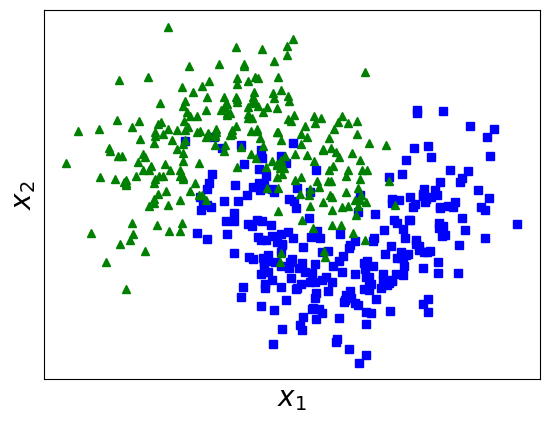

In [11]:
# 1- Generating a dataset.
from sklearn.datasets import make_moons
 
# X are the generated instances, an array of shape (500,2).
# y are the labels of X, with values of either 0 or 1.
X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
print("X: ", X)

# 2- Visualizing the dataset.
from matplotlib import pyplot as plt

# https://numpy.org/doc/stable/user/basics.indexing.html#advanced-indexing
# When the label y is 0, the class is represented with a blue square.
# When the label y is 1, the class is represented with a green triangle.
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "g^")

# X contains two features, x1 and x2
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$", fontsize=20)

# Simplifying the plot by removing the axis scales.
plt.xticks([])
plt.yticks([])

# Displaying the plot.
plt.show()

Let's build a voting classifier:

In [12]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [13]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


In [22]:
voting_clf.predict(X_test[:1])

array([1])

In [23]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1]), array([1]), array([0])]

In [24]:
voting_clf.score(X_test, y_test)

0.912

Now let's use soft voting:

In [25]:
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

# Bagging and Pasting
## Bagging and Pasting in Scikit-Learn

The following code trains an ensemble of **500 decision tree classifiers**: each is trained on **100 training instances randomly sampled from the training set with replacement** (this is an example of bagging, but if you want to use pasting instead, Must set bootstrap=False). The n_jobs parameter tells Scikit-Learn the number of CPU cores to use for training and predictions, and –1 tells Scikit-Learn to use all available cores:

In [27]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

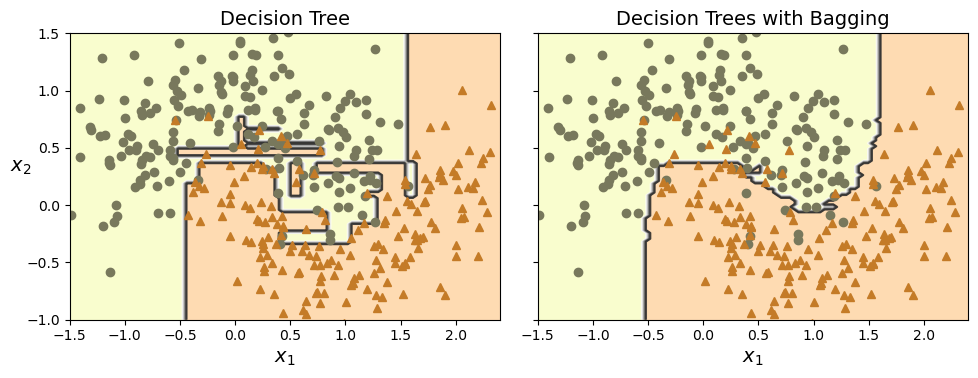

In [28]:
# extra code – this cell generates and saves Figure 7–5

def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging")
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

## Out-of-Bag evaluation

In [29]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            oob_score=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

In [31]:
bag_clf.oob_decision_function_[:3]  # probas for the first 3 instances

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

In [32]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

If you randomly draw one instance from a dataset of size _m_, each instance in the dataset obviously has probability 1/_m_ of getting picked, and therefore it has a probability 1 – 1/_m_ of _not_ getting picked. If you draw _m_ instances with replacement, all draws are independent and therefore each instance has a probability (1 – 1/_m_)<sup>_m_</sup> of _not_ getting picked. Now let's use the fact that exp(_x_) is equal to the limit of (1 + _x_/_m_)<sup>_m_</sup> as _m_ approaches infinity. So if _m_ is large, the ratio of out-of-bag instances will be about exp(–1) ≈ 0.37. So roughly 63% (1 – 0.37) will be sampled.

In [ ]:
# extra code – shows how to compute the 63% proba
print(1 - (1 - 1 / 1000) ** 1000)
print(1 - np.exp(-1))

0.6323045752290363
0.6321205588285577


# Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                 n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

A Random Forest is equivalent to a bag of decision trees:

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, n_jobs=-1, random_state=42)

In [ ]:
# extra code – verifies that the predictions are identical
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)
np.all(y_pred_bag == y_pred_rf)  # same predictions

True

## Feature Importance

In [ ]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)
for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


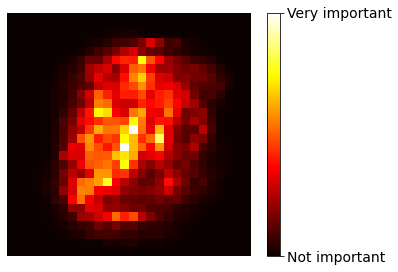

In [ ]:
# extra code – this cell generates and saves Figure 7–6

from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False,
                                parser='auto')

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'], fontsize=14)
plt.axis("off")
save_fig("mnist_feature_importance_plot")
plt.show()

# Boosting
## AdaBoost

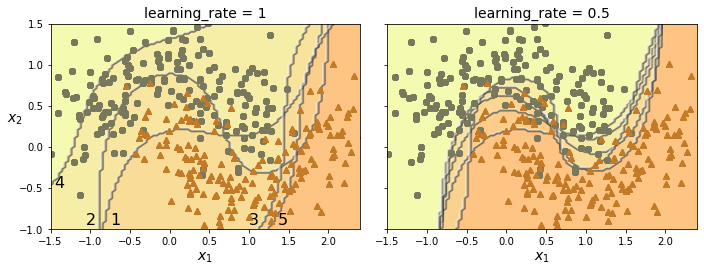

In [ ]:
# extra code – this cell generates and saves Figure 7–8

m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        error_weights = sample_weights[y_pred != y_train].sum()
        r = error_weights / sample_weights.sum()  # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r)  # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha)  # equation 7-3
        sample_weights /= sample_weights.sum()  # normalization step

        plot_decision_boundary(svm_clf, X_train, y_train, alpha=0.4)
        plt.title(f"learning_rate = {learning_rate}")
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=16)
        plt.text(-1.05, -0.95, "2", fontsize=16)
        plt.text(1.0, -0.95, "3", fontsize=16)
        plt.text(-1.45, -0.5, "4", fontsize=16)
        plt.text(1.36,  -0.95, "5", fontsize=16)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=30,
    learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

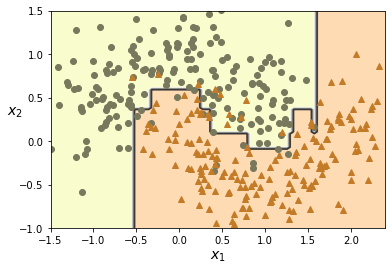

In [ ]:
# extra code – in case you're curious to see what the decision boundary
#              looks like for the AdaBoost classifier
plot_decision_boundary(ada_clf, X_train, y_train)

## Gradient Boosting

Let's create a simple quadratic dataset and fit a `DecisionTreeRegressor` to it:

In [26]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)  # y = 3x² + Gaussian noise

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now let's train another decision tree regressor on the residual errors made by the previous predictor:

In [27]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=43)

In [28]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=44)

In [29]:
X_new = np.array([[-0.4], [0.], [0.5]])
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([0.49484029, 0.04021166, 0.75026781])

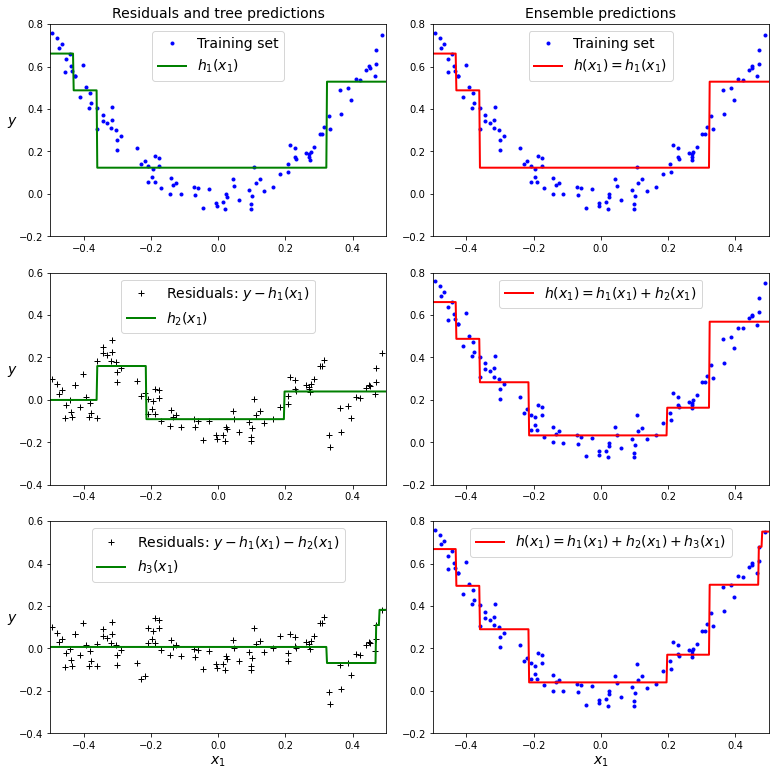

In [30]:
# extra code – this cell generates and saves Figure 7–9

def plot_predictions(regressors, X, y, axes, style,
                     label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))
                 for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)

plt.figure(figsize=(11, 11))

plt.subplot(3, 2, 1)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="g-",
                 label="$h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$  ", rotation=0)
plt.title("Residuals and tree predictions")

plt.subplot(3, 2, 2)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.title("Ensemble predictions")

plt.subplot(3, 2, 3)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_2(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1)$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 4)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.2, 0.8],
                  style="r-", label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

plt.subplot(3, 2, 5)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_3(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1) - h_2(x_1)$")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 6)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y,
                 axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$")

save_fig("gradient_boosting_plot")
plt.show()

Now let's try a gradient boosting regressor:

In [31]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3,
                                 learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [32]:
gbrt_best = GradientBoostingRegressor(
    max_depth=2, learning_rate=0.05, n_estimators=500,
    n_iter_no_change=10, random_state=42)
gbrt_best.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

In [33]:
gbrt_best.n_estimators_

92

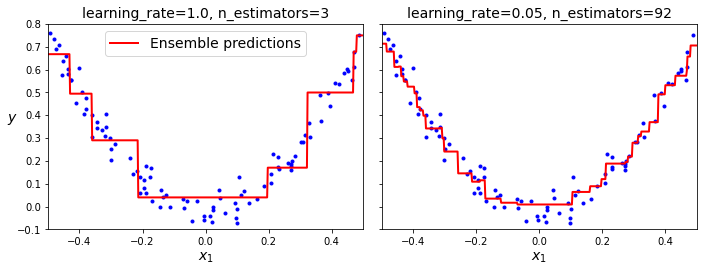

In [34]:
# extra code – this cell generates and saves Figure 7–10

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-",
                 label="Ensemble predictions")
plt.title(f"learning_rate={gbrt.learning_rate}, "
          f"n_estimators={gbrt.n_estimators_}")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-")
plt.title(f"learning_rate={gbrt_best.learning_rate}, "
          f"n_estimators={gbrt_best.n_estimators_}")
plt.xlabel("$x_1$")

save_fig("gbrt_learning_rate_plot")
plt.show()

In [35]:
# extra code – at least not in this chapter, it's presented in chapter 2

import pandas as pd
from sklearn.model_selection import train_test_split
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
housing_labels = train_set["median_house_value"]
housing = train_set.drop("median_house_value", axis=1)

In [36]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder 

hgb_reg = make_pipeline(
    make_column_transformer((OrdinalEncoder(), ["ocean_proximity"]),
                            remainder="passthrough"),
    HistGradientBoostingRegressor(categorical_features=[0], random_state=42)
)
hgb_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['ocean_proximity'])])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(categorical_features=[0],
                                               random_state=42))])

In [37]:
# extra code – evaluate the RMSE stats for the hgb_reg model

from sklearn.model_selection import cross_val_score

hgb_rmses = -cross_val_score(hgb_reg, housing, housing_labels,
                             scoring="neg_root_mean_squared_error", cv=10)
pd.Series(hgb_rmses).describe()

count       10.000000
mean     47613.307194
std       1295.422509
min      44963.213061
25%      47001.233485
50%      48000.963564
75%      48488.093243
max      49176.368465
dtype: float64

# Stacking

In [38]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator=RandomForestClassifier(random_state=43),
    cv=5  # number of cross-validation folds
)
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=43))

In [39]:
stacking_clf.score(X_test, y_test)

0.928

# Exercise solutions

## 1. to 7.

1. If you have trained five different models and they all achieve 95% precision, you can try combining them into a voting ensemble, which will often give you even better results. It works better if the models are very different (e.g., an SVM classifier, a Decision Tree classifier, a Logistic Regression classifier, and so on). It is even better if they are trained on different training instances (that's the whole point of bagging and pasting ensembles), but if not this will still be effective as long as the models are very different.
2. A hard voting classifier just counts the votes of each classifier in the ensemble and picks the class that gets the most votes. A soft voting classifier computes the average estimated class probability for each class and picks the class with the highest probability. This gives high-confidence votes more weight and often performs better, but it works only if every classifier is able to estimate class probabilities (e.g., for the SVM classifiers in Scikit-Learn you must set `probability=True`).
3. It is quite possible to speed up training of a bagging ensemble by distributing it across multiple servers, since each predictor in the ensemble is independent of the others. The same goes for pasting ensembles and Random Forests, for the same reason. However, each predictor in a boosting ensemble is built based on the previous predictor, so training is necessarily sequential, and you will not gain anything by distributing training across multiple servers. Regarding stacking ensembles, all the predictors in a given layer are independent of each other, so they can be trained in parallel on multiple servers. However, the predictors in one layer can only be trained after the predictors in the previous layer have all been trained.
4. With out-of-bag evaluation, each predictor in a bagging ensemble is evaluated using instances that it was not trained on (they were held out). This makes it possible to have a fairly unbiased evaluation of the ensemble without the need for an additional validation set. Thus, you have more instances available for training, and your ensemble can perform slightly better.
5. When you are growing a tree in a Random Forest, only a random subset of the features is considered for splitting at each node. This is true as well for Extra-Trees, but they go one step further: rather than searching for the best possible thresholds, like regular Decision Trees do, they use random thresholds for each feature. This extra randomness acts like a form of regularization: if a Random Forest overfits the training data, Extra-Trees might perform better. Moreover, since Extra-Trees don't search for the best possible thresholds, they are much faster to train than Random Forests. However, they are neither faster nor slower than Random Forests when making predictions.
6. If your AdaBoost ensemble underfits the training data, you can try increasing the number of estimators or reducing the regularization hyperparameters of the base estimator. You may also try slightly increasing the learning rate.
7. If your Gradient Boosting ensemble overfits the training set, you should try decreasing the learning rate. You could also use early stopping to find the right number of predictors (you probably have too many).

## 8. Voting Classifier

Exercise: _Load the MNIST data and split it into a training set, a validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for validation, and 10,000 for testing)._

The MNIST dataset was loaded earlier. The dataset is already split into a training set (the first 60,000 instances) and a test set (the last 10,000 instances), and the training set is already shuffled. So all we need to do is to take the first 50,000 instances for the new training set, the next 10,000 for the validation set, and the last 10,000 for the test set:

In [40]:
X_train, y_train = X_mnist[:50_000], y_mnist[:50_000]
X_valid, y_valid = X_mnist[50_000:60_000], y_mnist[50_000:60_000]
X_test, y_test = X_mnist[60_000:], y_mnist[60_000:]

Exercise: _Then train various classifiers, such as a Random Forest classifier, an Extra-Trees classifier, and an SVM._

In [41]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

Note: The `LinearSVC` has a `dual` hyperparameter whose default value will change from `True` to `"auto"` in Scikit-Learn 1.5. To ensure this notebook continues to produce the same outputs, I'm setting it explicitly to `True`. Please see the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) for more details.

In [42]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(max_iter=100, tol=20, dual=True, random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [43]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier(random_state=42)
Training the ExtraTreesClassifier(random_state=42)
Training the LinearSVC(max_iter=100, random_state=42, tol=20)
Training the MLPClassifier(random_state=42)


In [44]:
[estimator.score(X_valid, y_valid) for estimator in estimators]

[0.9736, 0.9743, 0.8662, 0.966]

The linear SVM is far outperformed by the other classifiers. However, let's keep it for now since it may improve the voting classifier's performance.

Exercise: _Next, try to combine \[the classifiers\] into an ensemble that outperforms them all on the validation set, using a soft or hard voting classifier._

In [45]:
from sklearn.ensemble import VotingClassifier

In [46]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

In [47]:
voting_clf = VotingClassifier(named_estimators)

In [48]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf',
                              LinearSVC(max_iter=100, random_state=42, tol=20)),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [49]:
voting_clf.score(X_valid, y_valid)

0.9758

The `VotingClassifier` made a clone of each classifier, and it trained the clones using class indices as the labels, not the original class names. Therefore, to evaluate these clones we need to provide class indices as well. To convert the classes to class indices, we can use a `LabelEncoder`:

In [50]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_valid_encoded = encoder.fit_transform(y_valid)

However, in the case of MNIST, it's simpler to just convert the class names to integers, since the digits match the class ids:

In [51]:
y_valid_encoded = y_valid.astype(np.int64)

Now let's evaluate the classifier clones:

In [52]:
[estimator.score(X_valid, y_valid_encoded)
 for estimator in voting_clf.estimators_]

[0.9736, 0.9743, 0.8662, 0.966]

Let's remove the SVM to see if performance improves. It is possible to remove an estimator by setting it to `"drop"` using `set_params()` like this:

In [53]:
voting_clf.set_params(svm_clf="drop")

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf', 'drop'),
                             ('mlp_clf', MLPClassifier(random_state=42))])

This updated the list of estimators:

In [54]:
voting_clf.estimators

[('random_forest_clf', RandomForestClassifier(random_state=42)),
 ('extra_trees_clf', ExtraTreesClassifier(random_state=42)),
 ('svm_clf', 'drop'),
 ('mlp_clf', MLPClassifier(random_state=42))]

However, it did not update the list of _trained_ estimators:

In [55]:
voting_clf.estimators_

[RandomForestClassifier(random_state=42),
 ExtraTreesClassifier(random_state=42),
 LinearSVC(max_iter=100, random_state=42, tol=20),
 MLPClassifier(random_state=42)]

In [56]:
voting_clf.named_estimators_

{'random_forest_clf': RandomForestClassifier(random_state=42),
 'extra_trees_clf': ExtraTreesClassifier(random_state=42),
 'svm_clf': LinearSVC(max_iter=100, random_state=42, tol=20),
 'mlp_clf': MLPClassifier(random_state=42)}

So we can either fit the `VotingClassifier` again, or just remove the SVM from the list of trained estimators, both in `estimators_` and `named_estimators_`:

In [57]:
svm_clf_trained = voting_clf.named_estimators_.pop("svm_clf")
voting_clf.estimators_.remove(svm_clf_trained)

Now let's evaluate the `VotingClassifier` again:

In [58]:
voting_clf.score(X_valid, y_valid)

0.9769

A bit better! The SVM was hurting performance. Now let's try using a soft voting classifier. We do not actually need to retrain the classifier, we can just set `voting` to `"soft"`:

In [59]:
voting_clf.voting = "soft"

In [60]:
voting_clf.score(X_valid, y_valid)

0.9724

Nope, hard voting wins in this case.

_Once you have found \[an ensemble that performs better than the individual predictors\], try it on the test set. How much better does it perform compared to the individual classifiers?_

In [61]:
voting_clf.voting = "hard"
voting_clf.score(X_test, y_test)

0.9727

In [62]:
[estimator.score(X_test, y_test.astype(np.int64))
 for estimator in voting_clf.estimators_]

[0.968, 0.9703, 0.965]

The voting classifier reduced the error rate of the best model from about 3% to 2.7%, which means 10% less errors.

## 9. Stacking Ensemble

Exercise: _Run the individual classifiers from the previous exercise to make predictions on the validation set, and create a new training set with the resulting predictions: each training instance is a vector containing the set of predictions from all your classifiers for an image, and the target is the image's class. Train a classifier on this new training set._

In [63]:
X_valid_predictions = np.empty((len(X_valid), len(estimators)), dtype=object)

for index, estimator in enumerate(estimators):
    X_valid_predictions[:, index] = estimator.predict(X_valid)

In [64]:
X_valid_predictions

array([['3', '3', '3', '3'],
       ['8', '8', '8', '8'],
       ['6', '6', '6', '6'],
       ...,
       ['5', '5', '5', '5'],
       ['6', '6', '6', '6'],
       ['8', '8', '8', '8']], dtype=object)

In [65]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True,
                                            random_state=42)
rnd_forest_blender.fit(X_valid_predictions, y_valid)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [66]:
rnd_forest_blender.oob_score_

0.9722

You could fine-tune this blender or try other types of blenders (e.g., an `MLPClassifier`), then select the best one using cross-validation, as always.

Exercise: _Congratulations, you have just trained a blender, and together with the classifiers they form a stacking ensemble! Now let's evaluate the ensemble on the test set. For each image in the test set, make predictions with all your classifiers, then feed the predictions to the blender to get the ensemble's predictions. How does it compare to the voting classifier you trained earlier?_

In [67]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=object)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [68]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [69]:
accuracy_score(y_test, y_pred)

0.9705

This stacking ensemble does not perform as well as the voting classifier we trained earlier.

Exercise: _Now try again using a `StackingClassifier` instead: do you get better performance? If so, why?_

Since `StackingClassifier` uses K-Fold cross-validation, we don't need a separate validation set, so let's join the training set and the validation set into a bigger training set:

In [70]:
X_train_full, y_train_full = X_mnist[:60_000], y_mnist[:60_000]

Now let's create and train the stacking classifier on the full training set:

**Warning**: the following cell will take quite a while to run (15-30 minutes depending on your hardware), as it uses K-Fold validation with 5 folds by default. It will train the 4 classifiers 5 times each on 80% of the full training set to make the predictions, plus one last time each on the full training set, and lastly it will train the final model on the predictions. That's a total of 25 models to train!

In [71]:
stack_clf = StackingClassifier(named_estimators,
                               final_estimator=rnd_forest_blender)
stack_clf.fit(X_train_full, y_train_full)

StackingClassifier(estimators=[('random_forest_clf',
                                RandomForestClassifier(random_state=42)),
                               ('extra_trees_clf',
                                ExtraTreesClassifier(random_state=42)),
                               ('svm_clf',
                                LinearSVC(max_iter=100, random_state=42,
                                          tol=20)),
                               ('mlp_clf', MLPClassifier(random_state=42))],
                   final_estimator=RandomForestClassifier(n_estimators=200,
                                                          oob_score=True,
                                                          random_state=42))

In [72]:
stack_clf.score(X_test, y_test)

0.9784

The `StackingClassifier` significantly outperforms the custom stacking implementation we tried earlier! This is for mainly two reasons:

* Since we could reclaim the validation set, the `StackingClassifier` was trained on a larger dataset.
* It used `predict_proba()` if available, or else `decision_function()` if available, or else `predict()`. This gave the blender much more nuanced inputs to work with.

And that's all for today, congratulations on finishing the chapter and the exercises!